In [1]:
import TACTS as ts
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Example Data : Drifting Logistic Map

Data must be in a numpy array of shape (D+1,T) where D is the dimension of data points and T is the number of time points. 

In [2]:
def logmap(r,x0, T):
    def logistic(r, x): 
        return r * x * (1 - x)
    t,x = np.arange(T),np.empty(T)
    x[0] = x0
    for i in range(1,T): 
        x[i] = logistic(r,x[i-1])
    return x

N = 10000
r = [3.5+(float(k)/float(2*N)) for k in range(int(N))]
F = np.empty(shape=(2,N))
F[0] = np.arange(0,N)
F[1][0] = logmap(r[0],0.1,2)[1]
for t in range(1,N):
    F[1][t] = logmap(r[t],F[1][t-1],2)[1]
    
FS = ts.RandomSampleSeries(F,8000)
FS = ts.addMeasurementNoise(FS, 0.1)

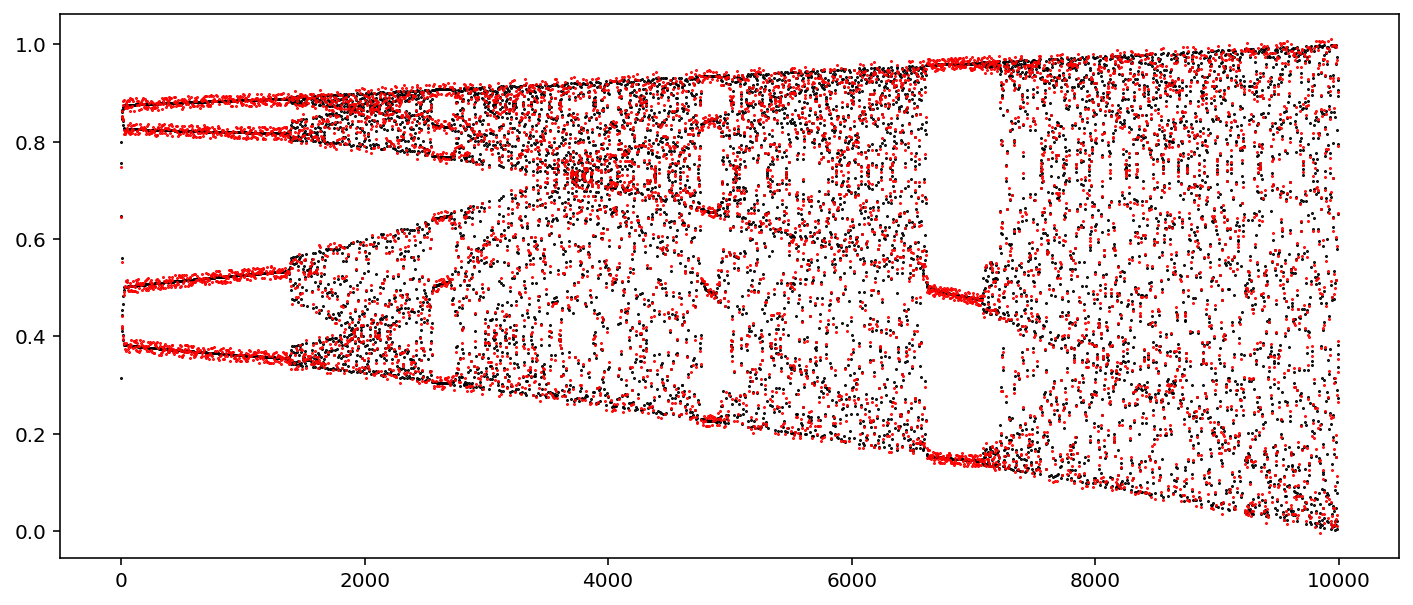

In [3]:
plt.figure(figsize=(12,5))
plt.plot(F[0],F[1],'.k', ms=1)
plt.plot(FS[0],FS[1],'.r', ms=1)
plt.show()

## Generating Single TACTS series

We can generate a single TACTS series by using `OptimizeWindow` and `Generate` methods. Supplying a specific regular timeline is possible by setting the keywords `T0`, `TN` and `dt`. In both functions, there are three different levels of verbosity/output depending on the value of the `report` keyword.

Optimizing W4.00  >> Res 20 / Focus 0.50 / Depth 2
Optimal Lambda : 2.1011695906432752
Confidence Interval : 0.03450292397660819
Search Size : 80  (BF : 171)


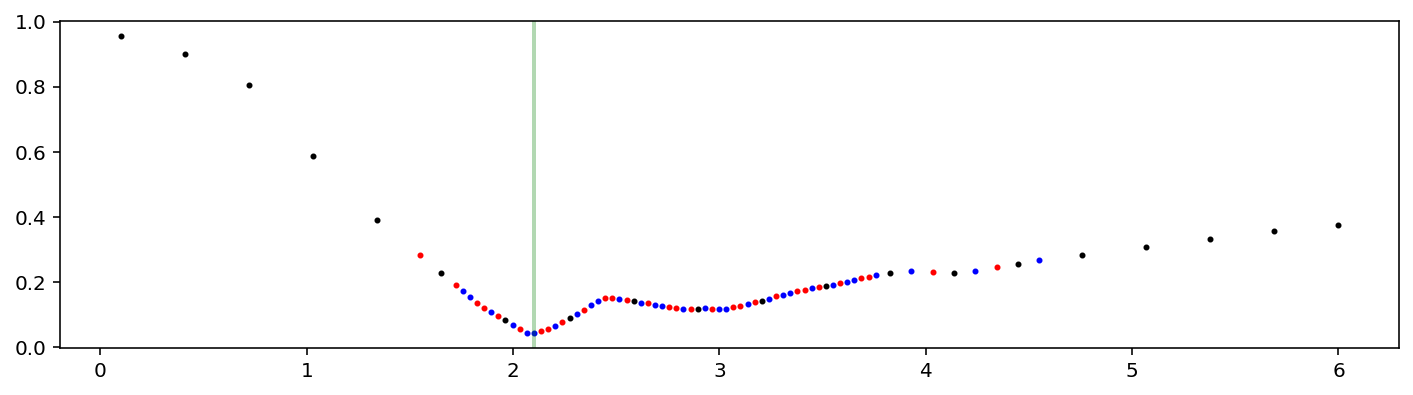

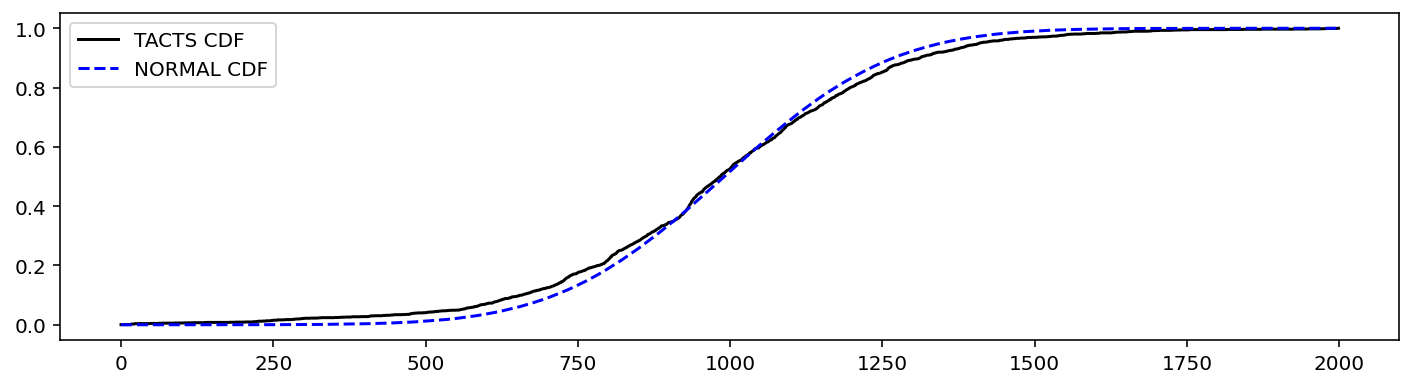

In [4]:
winsize = 4
bestlambda = ts.OptimizeWindow(FS, winsize, T0=None, TN=None, dt=None, 
                     Lmin=0.1, Lmax=6, ResZero=20, Focus=0.5, ResDepth=2, report=2, NORM_CDF=None)[2]

`Generate` method returns three objects: 
[0] numpy array containing the TACTS series , [1] index list of all empty windows , [2] binary mask of non-empty segments. Only the first item ([0]) is needed for most analyses.

Points in Segments : [1,5]
Forced Skips : 1885 Total (-4,3)
All Partial Paths > Shift : 10603  Insert : 21383
Average Skip Ratio : 0.2536071786071766
Avg. Shift Cost : 1.2868462799703673
Avg. Scale Cost : 2.5900296508057523
Dimensions : 1 
Datapoints : 8000
Window Size : 4.99962495311914
Tacts Length : 1998
Shift/Scale Unit Costs > > 0.8037637113817048 / 8.955799705543548
Ignore Cost > > 2.1011695906432752


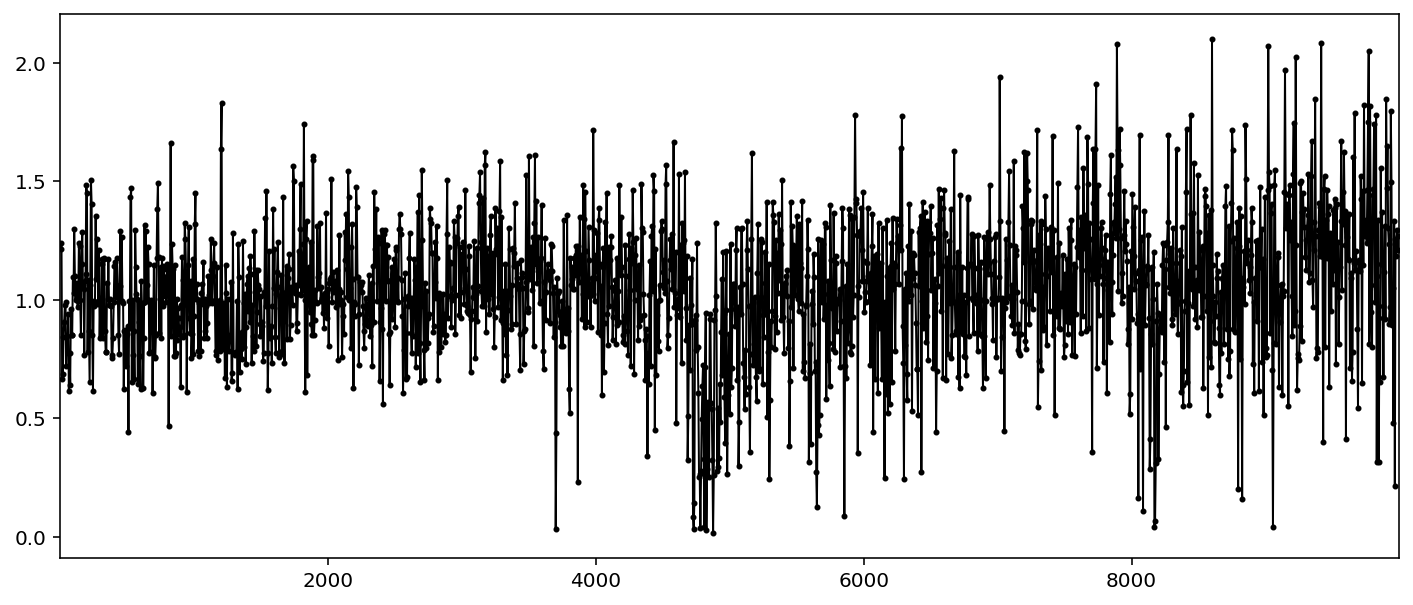

In [5]:
TACTS = ts.Generate(FS, winsize, p2=bestlambda, report=2, T0=None, TN=None, dt=None)[0]

Now we can fix a rolling window size and generate the DET values for some timeline using `RecurrenceWindows`:

Recurrence Data : 1998  /  frame : 200
Timeline : 1940    Threshold : 0.05765011032725841


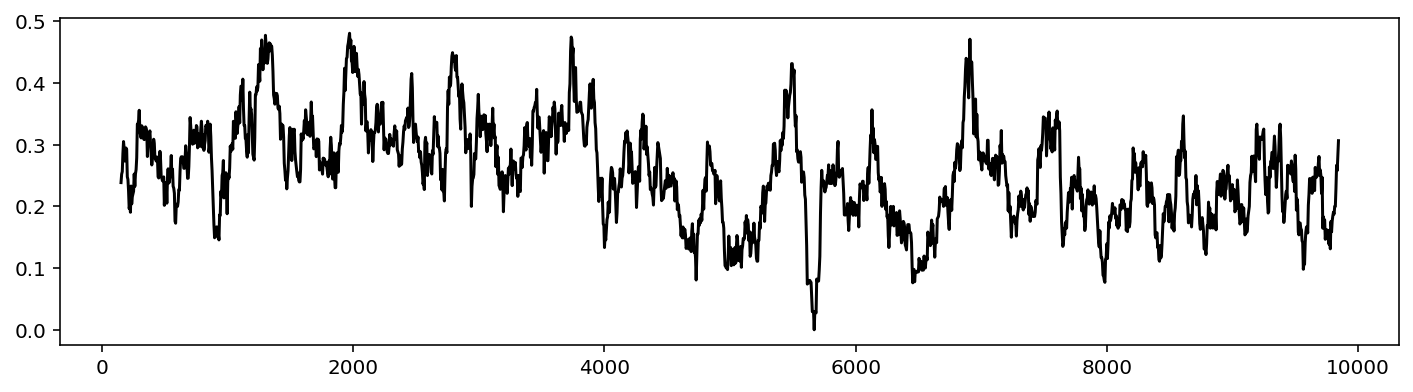

In [6]:
frame = 200
timeline = np.arange(150,9850,5)
DET = ts.RecurrenceWindows(TACTS, frame, timeline)[0]
plt.figure(figsize=(12,3))
plt.plot(timeline,DET,'-k', ms=1)
plt.show()

## Generating TACTS Spectrum

We can also optimize TACTS for a number of windowsizes using a single function: `OptimizeSpectrum`. Parallelization is over the windowsizes, so it is advisable to only generate a dense spectrum when there is an equal number of available processor cores expressed by the keyword argument `njobs`.

In [7]:
windowsizes = np.arange(4,9,.5)
T0,TN,dt = 50,9950, 1
OPT = ts.OptimizeSpectrum(FS, windowsizes, T0=T0, TN=TN, dt=dt, njobs=4,
                         Lmin=0.5 ,Lmax=6, ResZero=20, Focus=.3, ResDepth=2)

Optimizing 10 Windows  >> Res 20 / Focus 0.30 / Depth 2 | Workers : 4 .. Done.


we can use the `displayOptimization` method to display a summary of the optimization procedure.

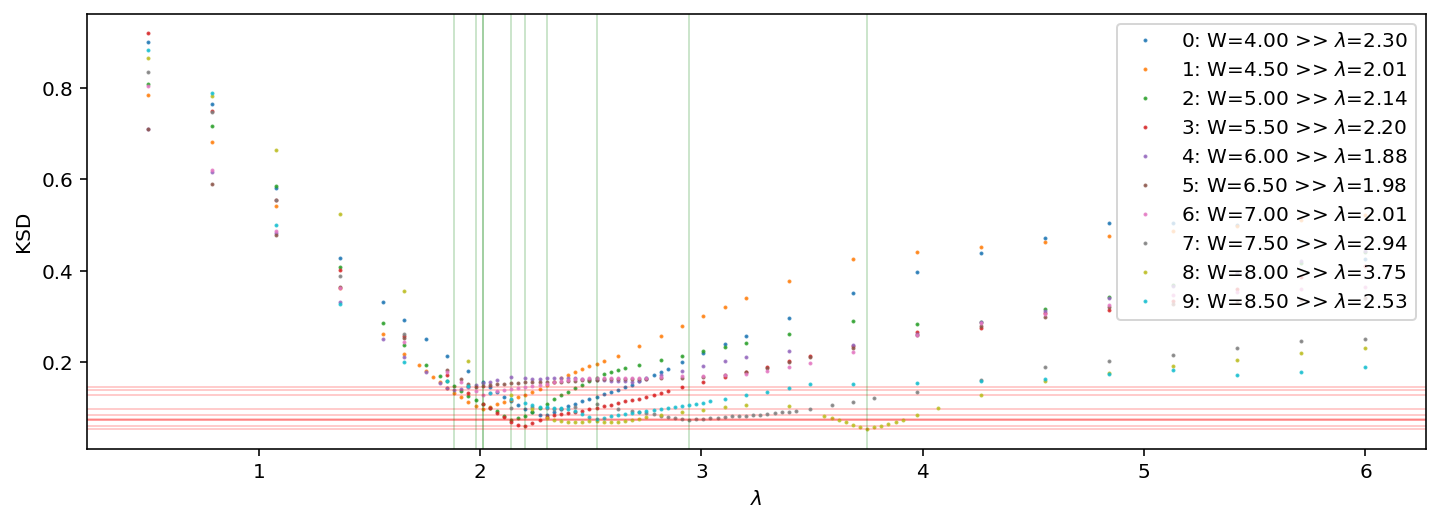

In [8]:
ts.displayOptimization(OPT, windowsizes, figsize=(12,4))

We use `GenerateSpectrum` to generate all TACTS series and `SweepDeterminism` to generate DET series for the spectrum. Again the parallelization is over the window sizes.

In [9]:
TW = ts.GenerateSpectrum(FS, windowsizes, OPT, T0=T0, TN=TN, dt=dt)

Generating TACTS (10) ..........Done.


In [10]:
frame = 100
timeline = np.arange(150,9850,1)
DETS, Pds = ts.SweepDeterminism(TW, frame, timeline, report=1, stdthr=0.1)

Compiling DETS (10) .......... Done.


We can optionally generate a number of DET surrogates to establish confidence levels and get the mean confidence intervals for the spectrum determinism.

In [11]:
CONF = ts.GetSpectrumConfidence(Pds, len(timeline), L=0.01, R=0.99, nofexp = 1000 )
MeanCONF = ts.GetMeanConfidence(CONF)

Measuring Confidences (10) .......... Done.


For a quick glance at the DET series, we can use the method `displaySpectrum`:

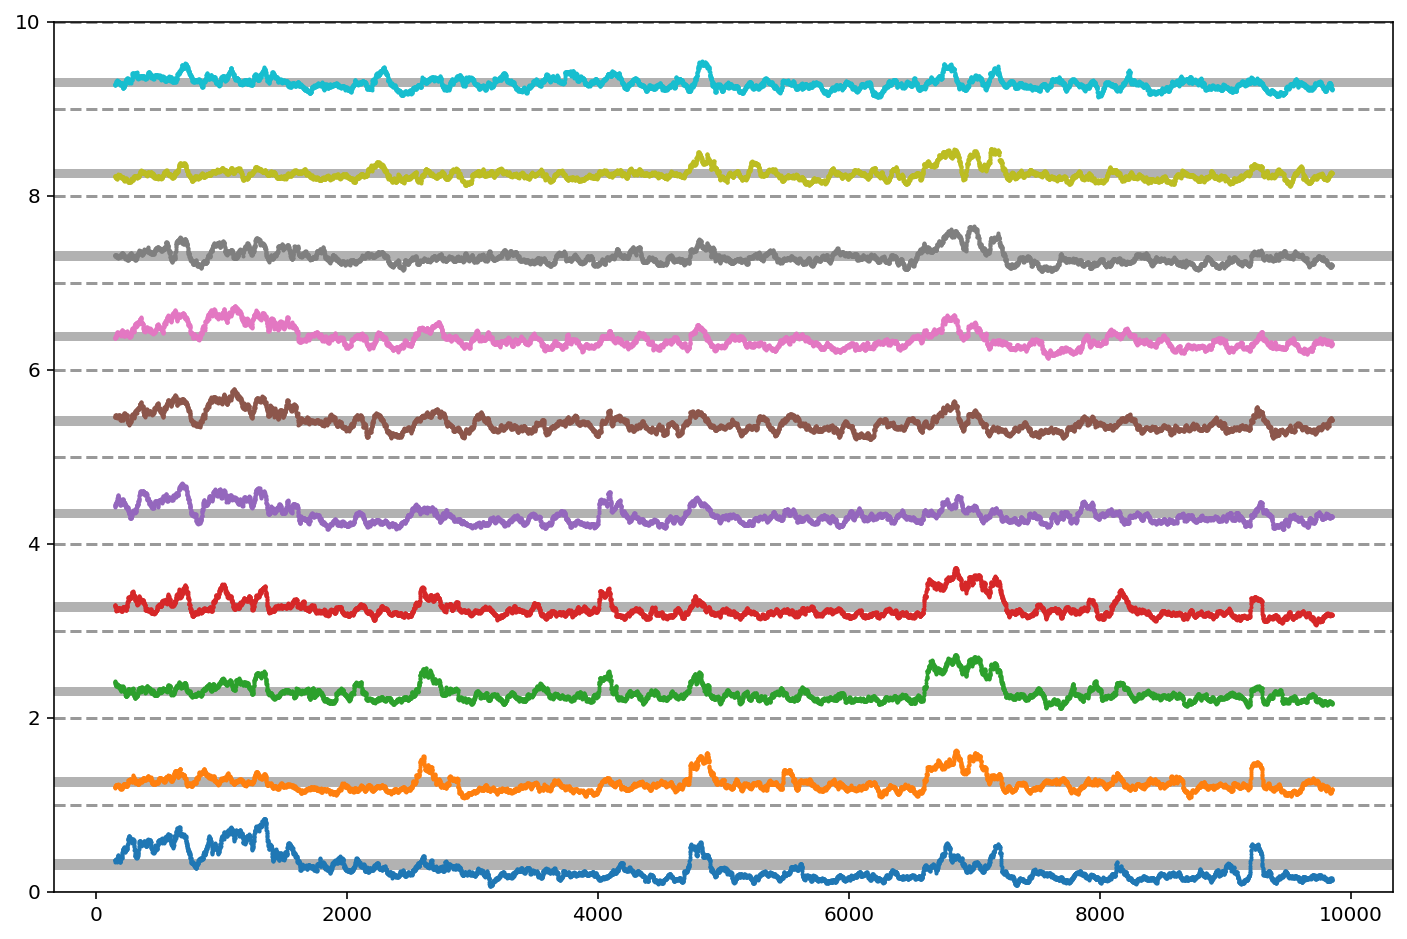

In [12]:
ts.displaySpectrum(timeline, DETS, figsize=(12,8), C=CONF)

We can see SDET for the data along with its confidence levels:

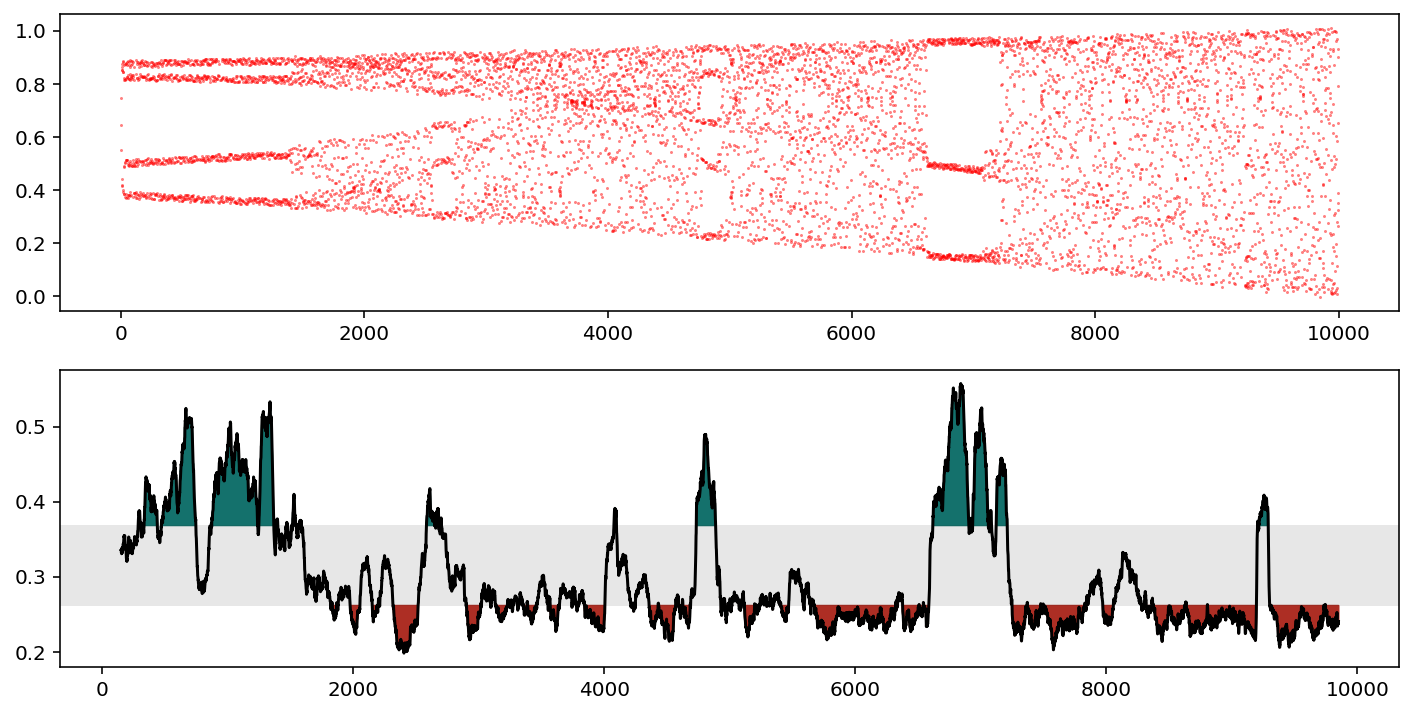

In [13]:
SDET = ts.CompileDETS(DETS)
plt.figure(figsize=(12,6))
plt.subplot(211);plt.plot(FS[0],FS[1],'.r', ms=1, alpha=0.5)
plt.subplot(212);plt.plot(timeline, SDET,'k')
ts.plotSpikes(plt.gca(), timeline, SDET, C_down=MeanCONF[0], C_up=MeanCONF[1], 
              colorL = '#ad2e24', colorH = '#14716c', colorM='0.1', stdthr=1, mask=None)
plt.show()